# Manual Time Synchronization

In [52]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import zoll
from utils import nirs
from utils import misc
from utils.autoscale import autoscale

In [53]:
# parameters
case_id = 1
step_id = 5

In [54]:
case_str = str(case_id).zfill(5)
output_file = f'output/{case_str}_{step_id}.csv'
input_file = 'output/' + case_str + '_3.csv'

In [55]:
# load data
df = pd.read_csv(input_file,
                 sep = ',',
                 na_values = ['-'],
                 parse_dates = ['Time'],
                 index_col='Time')

In [56]:
# load manually defined timeshifts
shift_df = pd.read_csv('amend/timeshift.csv', sep = ',')
manual_shift = shift_df.loc[shift_df['Case'] == case_id]['MAP_shift'].iloc[0]

In [57]:
df_out = df.copy()

In [58]:
# smooth rSO2 to match MAP
df['rSO2'] = df['rSO2'].rolling(10).mean()

In [59]:
# dropout
df['rSO2'] = np.where(df['Bad_rSO2_manual'] == 1, np.nan, df['rSO2'])
df['MAP'] = np.where(df['Bad_MAP_auto'] == 1, np.nan, df['MAP'])
df['MAP'] = np.where(df['Bad_MAP_manual'] == 1, np.nan, df['MAP'])

In [60]:
df_shifted = df.copy()
df_shifted = misc.ShiftMAP(df_shifted, manual_shift)

In [61]:
# resampling as per Ono, Joshi, Brady, Easley et al. 2012
df['MAP_resampled'] = df['MAP'].resample('10s').mean()
df['rSO2_resampled'] = df['rSO2'].resample('10s').mean()
df_shifted['MAP_resampled'] = df_shifted['MAP'].resample('10s').mean()
df_shifted['rSO2_resampled'] = df_shifted['rSO2'].resample('10s').mean()

In [62]:
def PlotTimeline(data, title):
    fig, ax1 = plt.subplots(figsize=(20,6))
    ax1.set_ylabel('rSO2', color='navy')
    line1 = ax1.plot(data.index, data['rSO2'], color='navy', label='rSO2')
    ax1.tick_params(axis='y', labelcolor='navy')
    ax2 = ax1.twinx()
    ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
    ax2.set_ylabel('MAP', color='maroon')
    line2 = ax2.plot(data.index, data['MAP'], color='maroon', label='MAP')
    ax2.tick_params(axis='y', labelcolor='maroon')
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='upper left')
    ax2.grid()
    plt.title(title)
    mark_timestamp = data.loc[data['Mark'] == 1].index[0]
    ax1.axvline(mark_timestamp, linestyle='--', linewidth=3)
    plt.autoscale(enable=True, axis="x", tight=True)

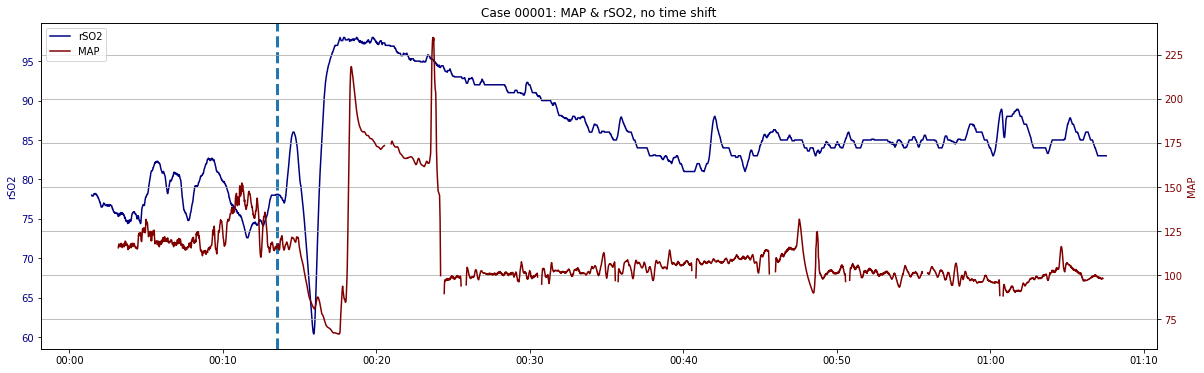

In [63]:
PlotTimeline(df, f'Case {case_str}: MAP & rSO2, no time shift')
plt.savefig(f'reports/images/{step_id}_{case_str}_01.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

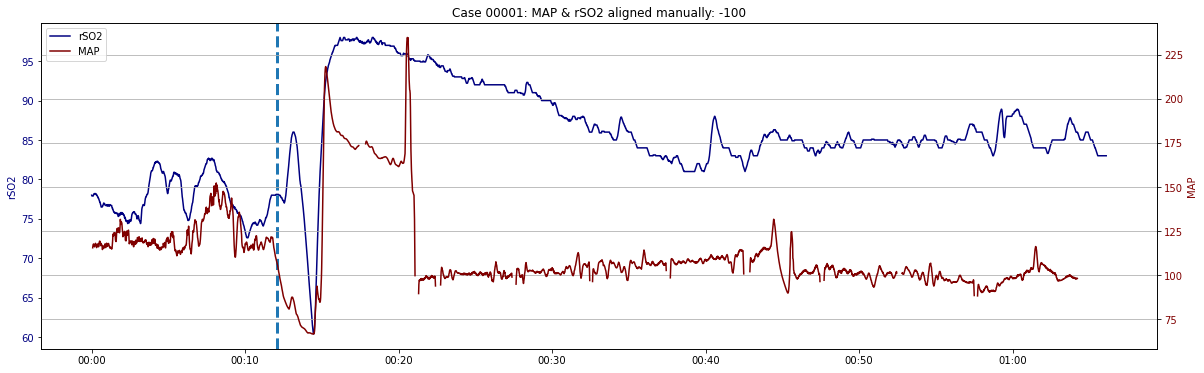

In [64]:
PlotTimeline(df_shifted, f'Case {case_str}: MAP & rSO2 aligned manually: {str(manual_shift)}')
plt.savefig(f'reports/images/{step_id}_{case_str}_02.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

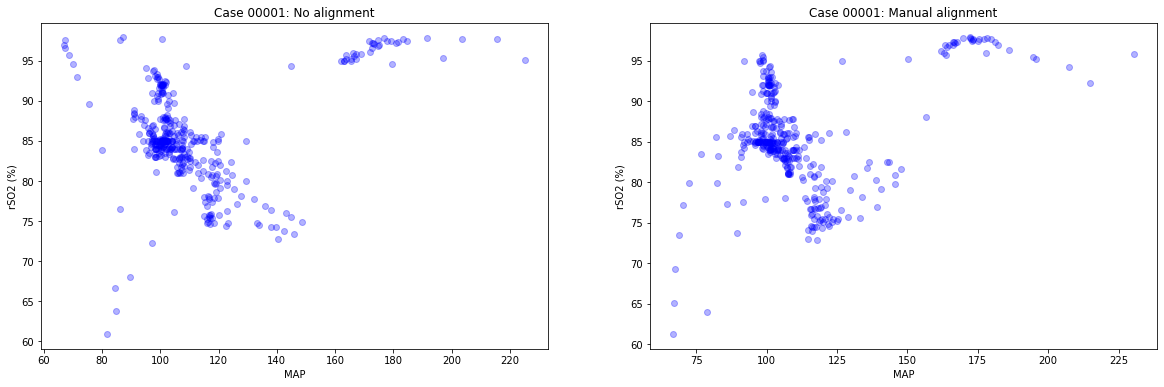

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

ax1.scatter(df['MAP_resampled'], df['rSO2_resampled'], alpha=0.3, c='b')
ax1.set_title(f'Case {case_str}: No alignment')
ax1.set_xlabel('MAP')
ax1.set_ylabel('rSO2 (%)')

ax2.scatter(df_shifted['MAP_resampled'], df_shifted['rSO2_resampled'], alpha=0.3, c='b')
ax2.set_title(f'Case {case_str}: Manual alignment')
ax2.set_xlabel('MAP')
ax2.set_ylabel('rSO2 (%)')

plt.savefig(f'reports/images/{step_id}_{case_str}_03.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [68]:
# save output
df_out = misc.ShiftMAP(df_out, manual_shift)
df_out['MAP_delay'] = np.nan
df_out['MAP_delay'][0] = manual_shift.astype(int)
df_out[['MAP', 'Bad_MAP_auto', 'Bad_MAP_manual', 'rSO2', 'Mark', 'Bad_rSO2_auto', 'Bad_rSO2_manual', 'MAP_delay']].to_csv(output_file, na_rep='-', date_format='%H:%M:%S')